In [0]:
#!unzip ./drive/'My Drive'/dataset/leapGestRecog.zip

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from datetime import datetime

In [0]:
# Parameters
BATCH_SIZE = 64
RESIZE = 256
EPOCHS = 10
MODEL = models.resnet101
OUR_TOPOLOGY = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
OPTIMIZER = optim.Adam
OPTIMIZER_PARAMETERS = {"lr": 0.003}

In [0]:
transform = transforms.Compose([
    transforms.Resize(RESIZE),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

alldataset = torchvision.datasets.ImageFolder(root='./leapGestRecog/00', transform=transform)

for i in range(1, 10):
    folder = torchvision.datasets.ImageFolder(root='./leapGestRecog/0{}'.format(i), transform=transform)
    alldataset = torch.utils.data.ConcatDataset([alldataset, folder])


def split_train_test(indices, seed=42):
    np.random.seed(seed)
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(
        alldataset, batch_size=BATCH_SIZE, sampler=train_sampler,
        num_workers=12
    )
    testloader = torch.utils.data.DataLoader(
        alldataset, batch_size=BATCH_SIZE, sampler=test_sampler,
    )
    return train_idx, trainloader, test_idx, testloader

num_train = len(alldataset)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))

train_idx, trainloader, test_idx, testloader = split_train_test(indices)
_, trainloader, _, validloader = split_train_test(train_idx)

classes = ('01_palm', '02_l', '03_fist', '04_fist_moved',
           '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down')

In [110]:
print(len(trainloader), len(validloader), len(testloader))

250 32 32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


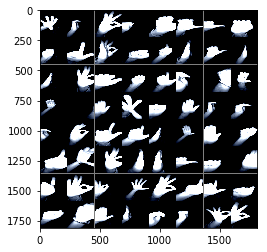

10_down  09_c 07_ok 04_fist_moved 05_thumb 05_thumb 05_thumb 03_fist 03_fist  02_l 07_ok 03_fist 06_index 08_palm_moved 05_thumb 08_palm_moved 08_palm_moved 07_ok 05_thumb 03_fist  02_l  09_c 04_fist_moved 10_down 10_down  02_l 01_palm 10_down 03_fist 01_palm  09_c  09_c  09_c 07_ok  02_l  02_l 08_palm_moved 10_down 01_palm 03_fist 06_index 10_down 07_ok 08_palm_moved 08_palm_moved 05_thumb 03_fist 01_palm 06_index 07_ok 07_ok 10_down 07_ok 06_index  02_l 03_fist 03_fist 05_thumb 01_palm 08_palm_moved  09_c 04_fist_moved 07_ok 07_ok


In [111]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [113]:

model = MODEL(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [114]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.fc = OUR_TOPOLOGY
criterion = nn.NLLLoss()
optimizer = OPTIMIZER(model.parameters(), **OPTIMIZER_PARAMETERS)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [115]:
epochs = EPOCHS
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

t1 = datetime.now()
for epoch in range(epochs):
    _, trainloader, _, validloader = split_train_test(train_idx)
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(validloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(validloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()
t2 = datetime.now()

Epoch 1/10.. Train loss: 2.747.. Test loss: 2.051.. Test accuracy: 0.399
Epoch 1/10.. Train loss: 1.462.. Test loss: 1.315.. Test accuracy: 0.526
Epoch 1/10.. Train loss: 0.760.. Test loss: 0.964.. Test accuracy: 0.663
Epoch 1/10.. Train loss: 0.601.. Test loss: 0.819.. Test accuracy: 0.737
Epoch 1/10.. Train loss: 0.443.. Test loss: 0.396.. Test accuracy: 0.887
Epoch 1/10.. Train loss: 0.365.. Test loss: 0.240.. Test accuracy: 0.953
Epoch 1/10.. Train loss: 0.265.. Test loss: 0.201.. Test accuracy: 0.944
Epoch 1/10.. Train loss: 0.307.. Test loss: 0.173.. Test accuracy: 0.942
Epoch 1/10.. Train loss: 0.211.. Test loss: 0.113.. Test accuracy: 0.976
Epoch 1/10.. Train loss: 0.138.. Test loss: 0.126.. Test accuracy: 0.966
Epoch 1/10.. Train loss: 0.155.. Test loss: 0.077.. Test accuracy: 0.984
Epoch 1/10.. Train loss: 0.164.. Test loss: 0.096.. Test accuracy: 0.976
Epoch 1/10.. Train loss: 0.114.. Test loss: 0.072.. Test accuracy: 0.987
Epoch 1/10.. Train loss: 0.143.. Test loss: 0.057..

Start time: 2019-10-06 21:34:57.558659
Finishing time: 2019-10-07 00:23:43.405432


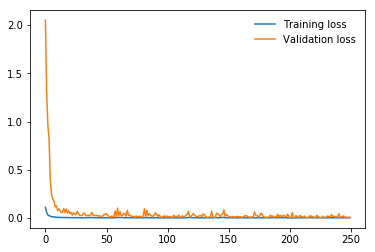

Test accuracy: 0.987


In [116]:
print("Start time: {}".format(t1))
print("Finishing time: {}".format(t2))

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()
accuracy = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)
        test_loss += batch_loss.item()

        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test accuracy: {accuracy/len(testloader):.3f}")